In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Conv2DTranspose, Reshape
from keras.models import Sequential, Model
from keras import backend as K
import os

C:\Users\DELL\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot_results(models, data, batch_size=32, model_name="autoencoder_2dim"):
    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "latent_2dim.png")
    # display a 2D plot of the digit classes in the latent space
    z = encoder.predict(x_test,
    batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z[:, 0], z[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of the digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = np.array([[xi, yi]])
            x_decoded = decoder.predict(z)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print(x_train.shape)
x_train = x_train/255.
x_test = x_test/255.

(60000, 28, 28, 1)


In [6]:
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noise = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noise = x_test + noise

x_train_noise = np.clip(x_train_noise, 0.0, 1.0)
x_test_noise = np.clip(x_test_noise, 0.0, 1.0)

In [7]:
# Encoder
inputs = Input(shape=(28,28,1))
y = Conv2D(32, (3,3), strides=2, padding='same', activation='relu')(inputs)
y = Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(y)
shape = K.int_shape(y)
print(shape)
y = Flatten()(y)
y = Dense(64, activation='relu')(y)
y = Dropout(0.2)(y)
outputs = Dense(2)(y)

encoder = Model(inputs=inputs, outputs=outputs)
#encoder.summary()

# Decoder
dinputs = Input(shape=(2,))
x = Dense(shape[1]*shape[2]*shape[3], activation='relu')(dinputs)
x = Reshape((shape[1],shape[2],shape[3]))(x)
x = Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(1, (3,3), strides=1, padding='same', activation='relu')(x)
decoder = Model(inputs=dinputs, outputs=x)
#decoder.summary()


# Autoencoder
autoencoder = Model(inputs=inputs, outputs=decoder(encoder(inputs)))
autoencoder.summary()

(None, 7, 7, 64)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 219714    
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         65089     
Total params: 284,803
Trainable params: 284,803
Non-trainable params: 0
_________________________________________________________________


In [8]:
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.fit(x_train_noise, x_train, validation_data = (x_test_noise, x_test), epochs=10, batch_size=32)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 27s 445us/step - loss: 0.0534 - val_loss: 0.0469
Epoch 2/10
60000/60000 [==============================] - 16s 272us/step - loss: 0.0469 - val_loss: 0.0443
Epoch 3/10
60000/60000 [==============================] - 17s 276us/step - loss: 0.0454 - val_loss: 0.0433
Epoch 4/10
60000/60000 [==============================] - 16s 264us/step - loss: 0.0446 - val_loss: 0.0429
Epoch 5/10
60000/60000 [==============================] - 16s 263us/step - loss: 0.0441 - val_loss: 0.0426
Epoch 6/10
60000/60000 [==============================] - 17s 276us/step - loss: 0.0439 - val_loss: 0.0424
Epoch 7/10
60000/60000 [==============================] - 16s 265us/step - loss: 0.0436 - val_loss: 0.0419
Epoch 8/10
60000/60000 [==============================] - 16s 266us/step - loss: 0.0434 - val_loss: 0.0420
Epoch 9/10
60000/60000 [==============================] - 16s 267us/step - loss: 0.0433 - val_

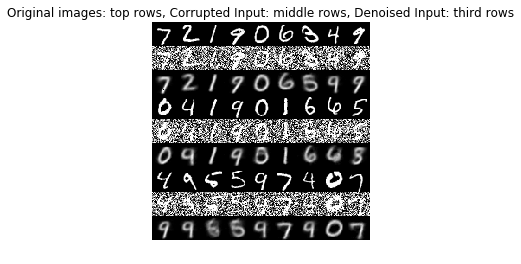

In [14]:
from PIL import Image
image_size = 28
# predict the autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noise)
# 3 sets of images with 9 MNIST digits
# 1st rows - original images
# 2nd rows - images corrupted by noise
# 3rd rows - denoised images
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noise[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
'Corrupted Input: middle rows, '
'Denoised Input: third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()